# Vote Count Cartograms Germany's Federal Election 2021

This notebook creates a cartogram of German electoral districts scaled by the **total number of second votes** (Zweitstimme) cast in the 2021 federal election. We will also make use of a hexagonal tiling of a cartogram.

## What is the Zweitstimme?

In Germany's mixed-member proportional system:
- **Erststimme (First Vote)**: Elects a local representative directly
- **Zweitstimme (Second Vote)**: Determines party proportions in the Bundestag

This cartogram distorts district areas to reflect where more votes were cast, giving urban areas with higher turnout more visual weight.

## Why Hexagonal Tiling?

Hexagonal tilings offer several advantages for visualizing geographic data:
- **Equal area representation**: Each hexagon represents the same visual weight
- **Reduces visual bias**: Eliminates the visual dominance of large, sparsely populated regions
- **Clean aesthetics**: Creates a more uniform look

In this example, we create a population density cartogram of German electoral districts and then convert it to a hexagonal tile representation.

In [1]:
from itertools import groupby
from copy import deepcopy

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.strtree import STRtree

from pycartogram.geopandas_cartogram import GeoDataFrameWardCartogram
from pycartogram.tools import fix_geodataframe_geometries, fix_invalid_geometry
from pycartogram.hexgrid import get_hexgrid

# Figure settings
plt.rcParams['figure.dpi'] = 150
_FIGSIZE = (7, 10)

## 1. Loading the Data

We need election statistics and electoral district boundaries.

We load two datasets:
- **btw21_stats.csv**: Election statistics including voter turnout and results
- **Geometrie_Wahlkreise_20DBT_VG250.json**: Electoral district boundaries

The coordinate reference system (CRS) is set to EPSG:25832 (UTM zone 32N), which is appropriate for Germany.

In [2]:
# Load election statistics
statsdata = pd.read_csv('data/btw21_stats.csv')
statsdata = statsdata.sort_values(by='wkr_nr')

# Load electoral district geometries
gdf = gpd.read_file("data/Geometrie_Wahlkreise_20DBT_VG250.json", crs='EPSG:32633')
gdf = gdf.set_crs('EPSG:25832', allow_override=True)

print(f"Loaded {len(gdf)} electoral districts")
print(f"CRS: {gdf.crs}")

Loaded 299 electoral districts
CRS: EPSG:25832


/Users/bfmaier/Dropbox/Archive/additional_datasets/german_geo_data/wahlkreise_cartograms/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/raw.py:200: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


### Calculating Vote Density

The Zweitstimme count is calculated as: `turnout_percentage × eligible_voters`

Vote density (votes per unit area) determines how much each district will expand or shrink in the cartogram.

In [3]:
# Calculate Zweitstimme count and density
# Zweitstimme = turnout percentage * eligible voters
areas = [shape.area for shape in gdf['geometry']]
gdf['area'] = areas
gdf['zweitstimme'] = statsdata['prozent_zweitstimme'] / 100 * statsdata['wahlberechtigte']
gdf['zweitstimme_density'] = gdf['zweitstimme'] / gdf['area']
gdf = gdf.sort_values(by='WKR_NR')

# Merge statistics data
for col in statsdata:
    gdf[col] = statsdata[col].to_list()

print(f"Zweitstimme range: {gdf['zweitstimme'].min():.0f} to {gdf['zweitstimme'].max():.0f}")
print(f"Density range: {gdf['zweitstimme_density'].min():.2e} to {gdf['zweitstimme_density'].max():.2e}")

Zweitstimme range: 40725 to 85973
Density range: 9.18e-06 to 3.35e-03


### Visualizing the Original Map

This shows vote density on the original geographic map. Note how large rural districts in eastern Germany have low density (dark colors), while urban areas have high density (bright colors).

(np.float64(200000.0),
 np.float64(1000000.0),
 np.float64(5200000.0),
 np.float64(6100000.0))

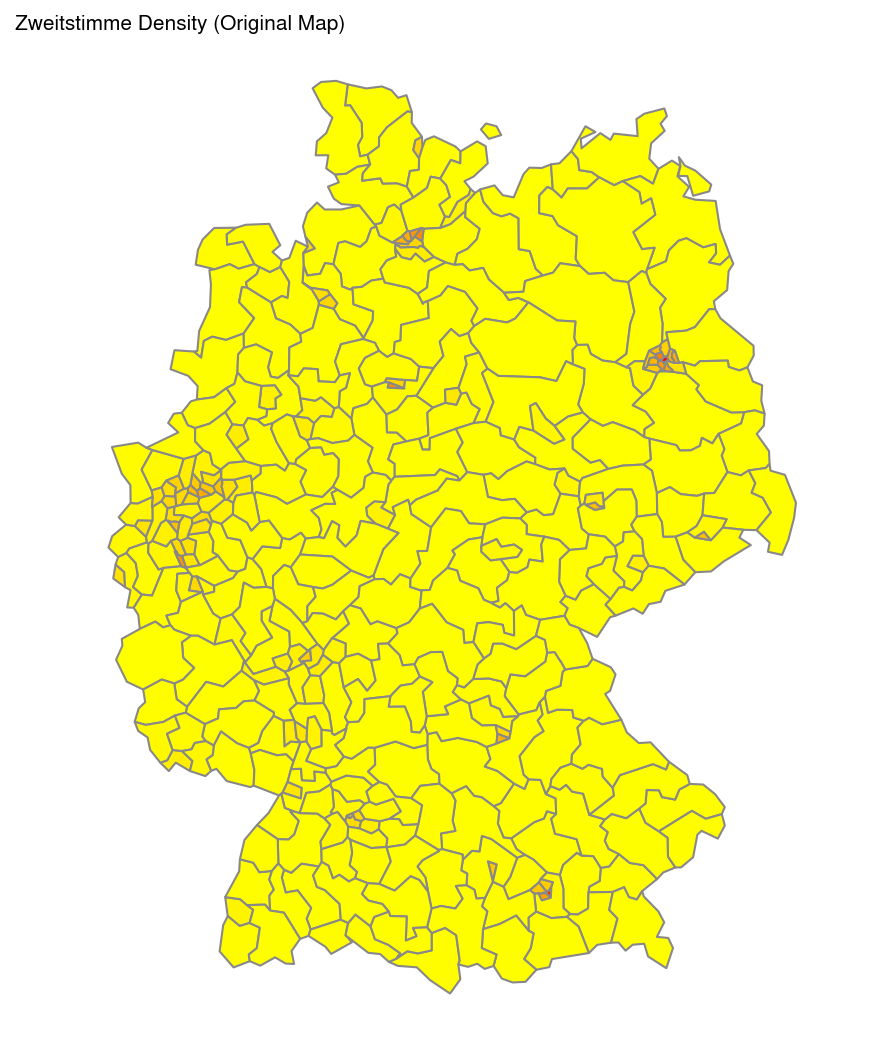

In [4]:
# Visualize vote density on the original map
ax = gdf.plot(column='zweitstimme_density', cmap='autumn_r', edgecolor='#888888', figsize=_FIGSIZE)
ax.set_title('Zweitstimme Density (Original Map)')
ax.axis('off')

## 2. Creating the Cartogram

We create a density-equalizing cartogram where district areas reflect the number of second votes cast.

### Before Cartogram: Area vs Votes

In the original map, there's no correlation between geographic area and vote count. Large districts don't necessarily have more votes - this is what we want to change.

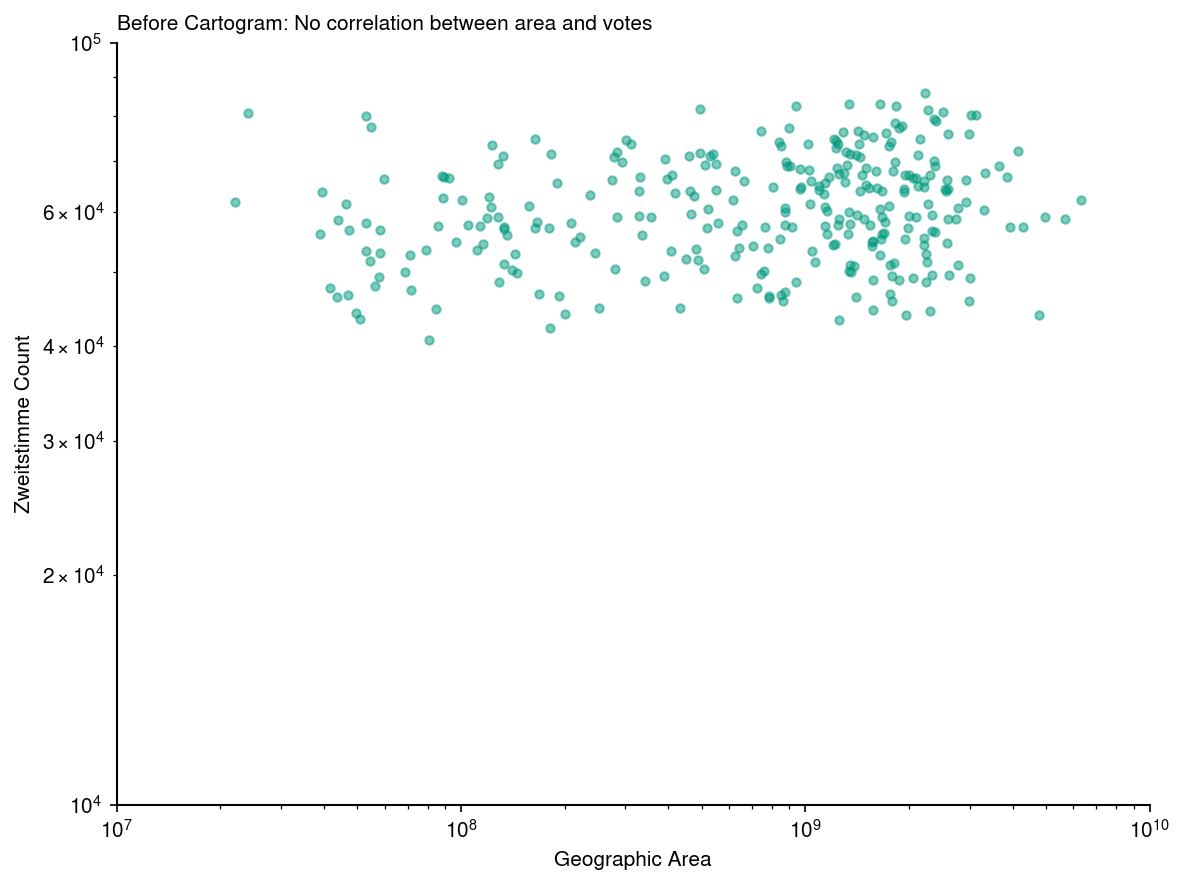

In [5]:
# Area vs votes relationship (before cartogram)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(gdf['area'], gdf['zweitstimme'], alpha=0.5)
ax.set_xlabel('Geographic Area')
ax.set_ylabel('Zweitstimme Count')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Before Cartogram: No correlation between area and votes')
plt.tight_layout()

### Creating the Cartogram Object

The `GeoDataFrameWardCartogram` class takes:
- The GeoDataFrame with district geometries
- The column containing density values
- Raster size parameters controlling the resolution of the diffusion algorithm

Higher raster sizes produce more accurate cartograms but take longer to compute.

In [6]:
# Create the cartogram
carto = GeoDataFrameWardCartogram(
    gdf,
    'zweitstimme_density',
    y_raster_size=2048,
    x_raster_size=768 * 2,
    map_orientation='portrait'
)

# Cast density to matrix (prepares the diffusion algorithm)
carto.cast_density_to_matrix(verbose=True, set_boundary_to='500percent_min');

cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:08<00:00, 34.02it/s]


### Density Matrix

The cartogram algorithm works by creating a density field and simulating diffusion. This visualization shows the density matrix before transformation.

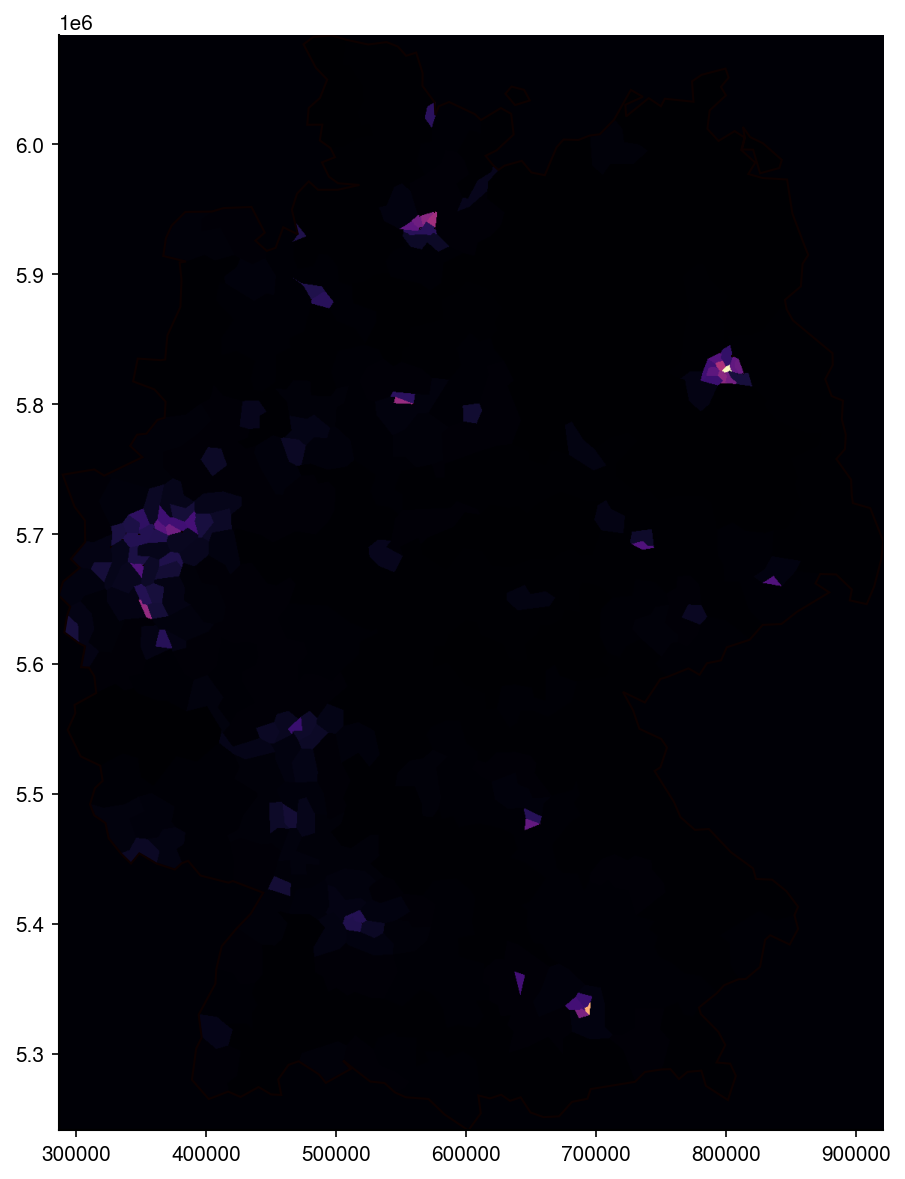

In [7]:
# Visualize the density matrix
carto.plot(show_new_wards=False, show_density_matrix=True, figsize=_FIGSIZE);

### Computing the Transformation

The cartogram transformation uses a diffusion-based algorithm. Points flow from high-density to low-density regions until the density is equalized. This process can take a minute or two.

In [8]:
# Compute the cartogram transformation
carto.compute(verbose=True)
new_gdf = carto.get_cartogram_geo_df()

  100%  |==================================================|



computing cartogram...


transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:08<00:00,  4.46it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 3 invalid (self-intersecting) polygon(s) at indices: [118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(


### Cartogram Result

The transformed map shows districts scaled by vote count. Urban areas (Berlin, Hamburg, Munich, Ruhr) are now much larger, while rural eastern districts have shrunk.

(np.float64(200000.0),
 np.float64(1000000.0),
 np.float64(5200000.0),
 np.float64(6100000.0))

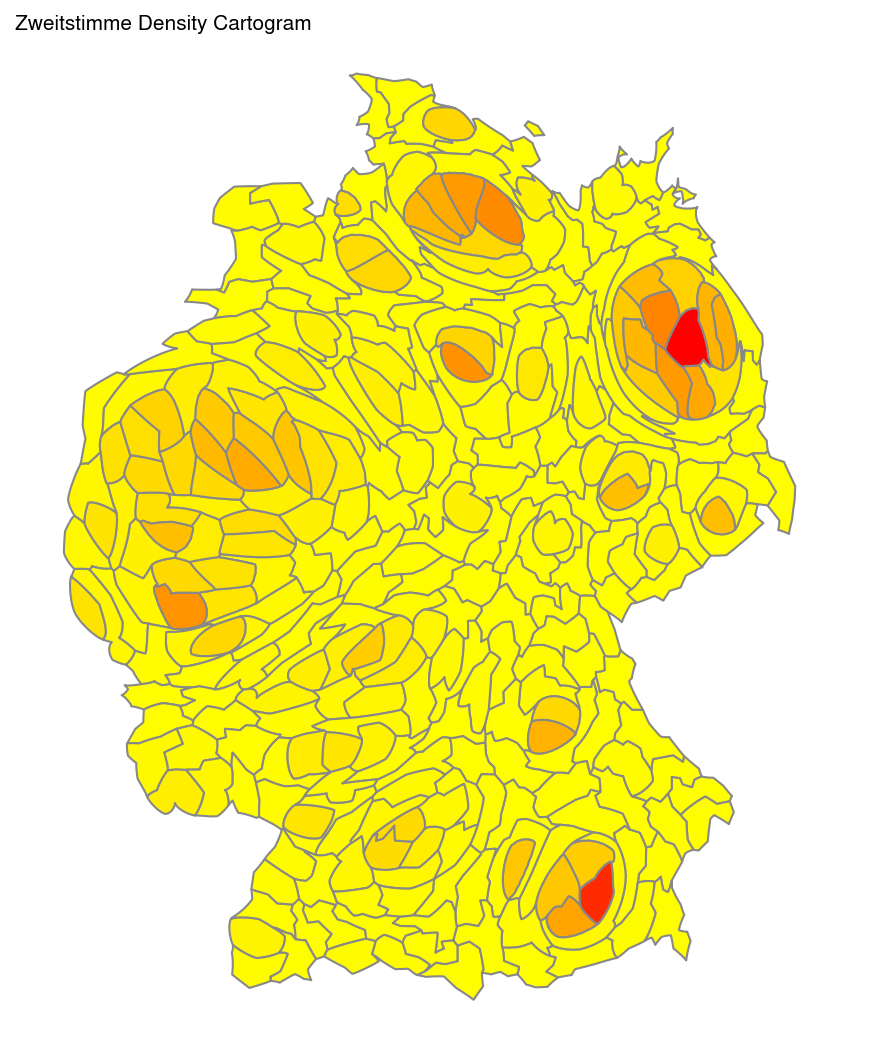

In [9]:
# Visualize the cartogram result
ax = new_gdf.plot(column='zweitstimme_density', edgecolor='#888888', cmap='autumn_r', figsize=_FIGSIZE)
ax.set_title('Zweitstimme Density Cartogram')
ax.axis('off')

### After Cartogram: Area vs Votes

Now there's a strong correlation between cartogram area and vote count - the transformation worked! Each district's visual size now reflects its voting weight.

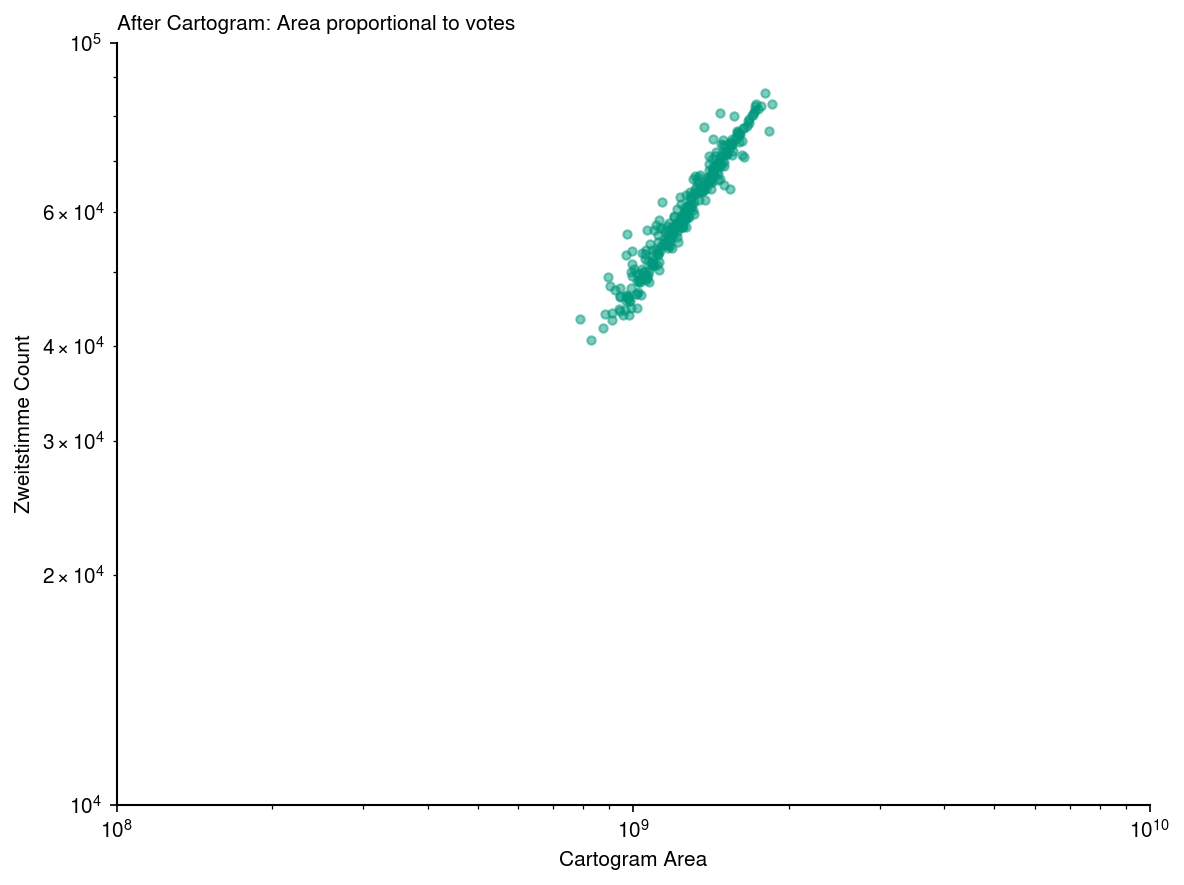

In [10]:
# Area vs votes relationship (after cartogram)
# Now areas should correlate with vote counts
new_areas = [a.area for a in new_gdf['geometry']]
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(new_areas, new_gdf['zweitstimme'], alpha=0.5)
ax.set_xlabel('Cartogram Area')
ax.set_ylabel('Zweitstimme Count')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('After Cartogram: Area proportional to votes')
plt.tight_layout()

## 3. Creating the Hexagonal Grid

We overlay a hexagonal grid on the cartogram for a cleaner tile-based visualization.

### Hexagon Grid Parameters

The `HEXAGON_GRID_SIZE` parameter controls the number of hexagons. Smaller values create more hexagons for finer detail but increase computation time.

In [11]:
# Configure hexagon grid size
HEXAGON_GRID_SIZE = 200

# Get the extent of the cartogram
ax = new_gdf.plot(column='zweitstimme_density', edgecolor='w', cmap='autumn_r')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
plt.close()

# Generate hexagonal grid
polygons = get_hexgrid(x0, y0, x1, y1, (x1 - x0) / HEXAGON_GRID_SIZE)
hexdf = gpd.GeoDataFrame(polygons, columns=['geometry'])

print(f"Created {len(hexdf)} hexagons")

Created 15096 hexagons


### Hexagon Grid Overlay

The hexagonal grid is overlaid on the cartogram. Each hexagon will be assigned to the district it overlaps most with.

(np.float64(0.0),
 np.float64(1200000.0),
 np.float64(5000000.0),
 np.float64(6400000.0))

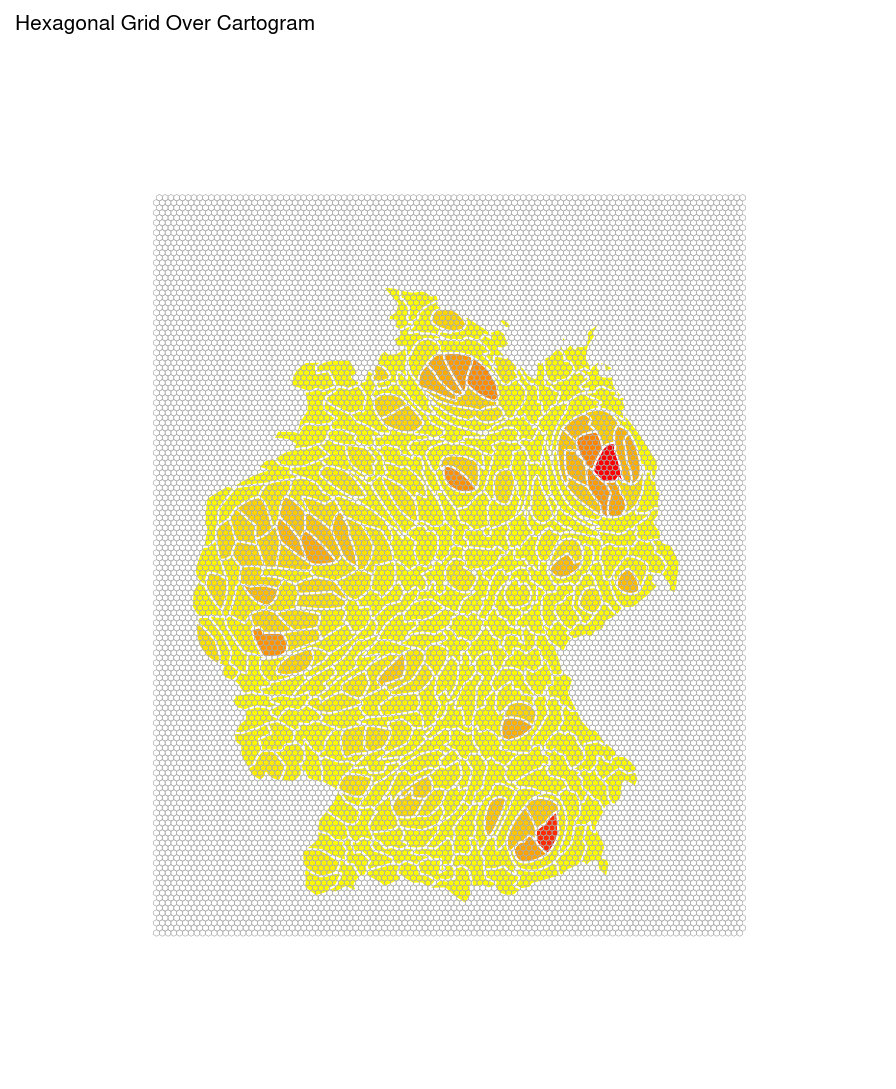

In [12]:
# Visualize the hexagonal grid overlay on the cartogram
ax = new_gdf.plot(column='zweitstimme_density', edgecolor='w', cmap='autumn_r', figsize=_FIGSIZE)
hexdf.plot(ax=ax, facecolor='None', edgecolor='#aaaaaa', lw=0.3)
ax.set_title('Hexagonal Grid Over Cartogram')
ax.axis('off')

## 4. Computing Hexagon-District Overlap

For each hexagon, we determine which electoral district it belongs to using spatial indexing.

### Spatial Indexing with STRtree

We use Shapely's STRtree (Sort-Tile-Recursive tree) for efficient spatial queries. This allows us to quickly find which districts each hexagon overlaps with, rather than checking every possible pair.

In [13]:
# Fix invalid geometries for intersection operations
target_polygons = [fix_invalid_geometry(g) for g in new_gdf['geometry']]
s = STRtree(target_polygons)
countyids = list(new_gdf['WKR_NR'])

# Compute overlap between each hexagon and all districts it intersects
overlap_data = []
for hex_id, source_polygon in hexdf.to_records():
    result_indices = s.query(source_polygon)
    these_overlap_counties = []
    these_overlap_areas = []
    total_overlap_area = 0.0
    
    for i in result_indices:
        target_poly = target_polygons[i]
        countyid = countyids[i]
        overlap = source_polygon.intersection(target_poly)
        area = overlap.area
        if area > 0:
            total_overlap_area += area
            these_overlap_counties.append(countyid)
            these_overlap_areas.append(area)
    
    if total_overlap_area > 0:
        overlap_data.extend([
            (int(hex_id), int(countyid), float(area / total_overlap_area))
            for countyid, area in zip(these_overlap_counties, these_overlap_areas)
        ])

overlap_df = pd.DataFrame(overlap_data, columns=['hexid', 'WKR_NR', 'overlap'])
print(f"Computed {len(overlap_df)} hexagon-district overlap relationships")

Computed 11712 hexagon-district overlap relationships


## 5. Assigning Hexagons to Districts

Each hexagon is assigned to the district it overlaps with most. We also handle districts that don't get any hexagons by "stealing" from neighbors.

### Assigning Hexagons

Each hexagon is assigned to the district it overlaps with most. We track which districts don't get any hexagons - these will need special handling.

In [14]:
# Assign each hexagon to the district with maximum overlap
idx = overlap_df.groupby(['hexid'])['overlap'].transform('max') == overlap_df['overlap']

hexagon_counties = [None for _ in range(len(hexdf))]
for hid, cid, _ in overlap_df[idx].to_records(index=False):
    hexagon_counties[hid] = cid

new_hexdf = hexdf.copy()
new_hexdf['WKR_NR'] = hexagon_counties

# Check for unassigned districts
assigned_counties = new_hexdf['WKR_NR'].unique()
assigned_counties = set(np.array(assigned_counties[~np.isnan(assigned_counties)], dtype=int).tolist())
all_counties = {int(c) for c in gdf['WKR_NR'].unique()}
unassigned_counties = all_counties - assigned_counties

print(f"Unassigned districts: {unassigned_counties if unassigned_counties else 'None'}")

Unassigned districts: None


### Handling Unassigned Districts

Small districts might not get any hexagons if they're smaller than a single hexagon. We solve this by "stealing" a hexagon from a neighboring district that has many hexagons.

In [15]:
# Handle unassigned districts by stealing hexagons from neighbors
if unassigned_counties:
    _hexagon = lambda x: x[0]
    _county = lambda x: x[1]
    _value = lambda x: x[2]
    
    # Assign a single district to each hexagon
    county_by_hex = {}
    data = sorted(overlap_data, key=_hexagon)
    for hex_id, grp in groupby(data, key=_hexagon):
        rows = [list(entry) for entry in grp]
        county_by_hex[hex_id] = _county(max(rows, key=_value))
    
    # Count hexagons per district
    data = sorted(county_by_hex.items(), key=_county)
    hexagon_count_by_county = {}
    for county, grp in groupby(data, key=_county):
        assigned_hexagons = [list(entry) for entry in grp]
        hexagon_count_by_county[county] = len(assigned_hexagons)
    
    # Group overlaps by district
    overlap_by_county = {}
    data = sorted(overlap_data, key=_county)
    for county, grp in groupby(data, key=_county):
        overlap_by_county[county] = [list(entry) for entry in grp]
    
    # Steal hexagons for unassigned districts
    for county in unassigned_counties:
        candidate_hexagons = [_hexagon(entry) for entry in overlap_by_county[county]]
        hex_ids = [
            (hex_id, county_by_hex[hex_id], hexagon_count_by_county[county_by_hex[hex_id]])
            for hex_id in candidate_hexagons
        ]
        this_hexagon = _hexagon(max(hex_ids, key=_value))
        hexagon_counties[this_hexagon] = county
        print(f"District {county} was assigned a hexagon from district {county_by_hex[this_hexagon]}")
    
    new_hexdf = hexdf.copy()
    new_hexdf['WKR_NR'] = hexagon_counties

## 6. Creating Hexagonal District Boundaries

We dissolve the hexagons by district ID to create smooth hexagonal boundaries.

### Dissolving Hexagons

Hexagons assigned to the same district are dissolved (merged) into a single polygon. A tiny buffer is applied to close any gaps between hexagons.

In [16]:
# Dissolve hexagons by district
hexa_counties = new_hexdf.dissolve(by='WKR_NR')

# Apply small buffer to close gaps between hexagons
hexa_counties_buf = hexa_counties.copy()
buffer_distance = np.sqrt(hexdf.iloc[0]['geometry'].area) / 10000000
buffered_polygons = [poly.buffer(buffer_distance) for poly in hexa_counties_buf['geometry']]
hexa_counties_buf['geometry'] = buffered_polygons

# Map back to original geodataframe structure
hexa_counties_buf.index = hexa_counties_buf.index.astype(int)
hexa_counties_buf_dict = dict(hexa_counties_buf.to_records())

new_geometry = [hexa_counties_buf_dict[int(cid)] for cid in new_gdf['WKR_NR']]
hexa_counties = new_gdf.copy()
hexa_counties['geometry'] = new_geometry

print(f"Created hexagonal boundaries for {len(hexa_counties)} districts")

Created hexagonal boundaries for 299 districts


### Hexagonal Tile Map

The final hexagonal representation where each district is composed of hexagonal tiles. State boundaries are overlaid for reference.

(np.float64(200000.0),
 np.float64(1000000.0),
 np.float64(5200000.0),
 np.float64(6100000.0))

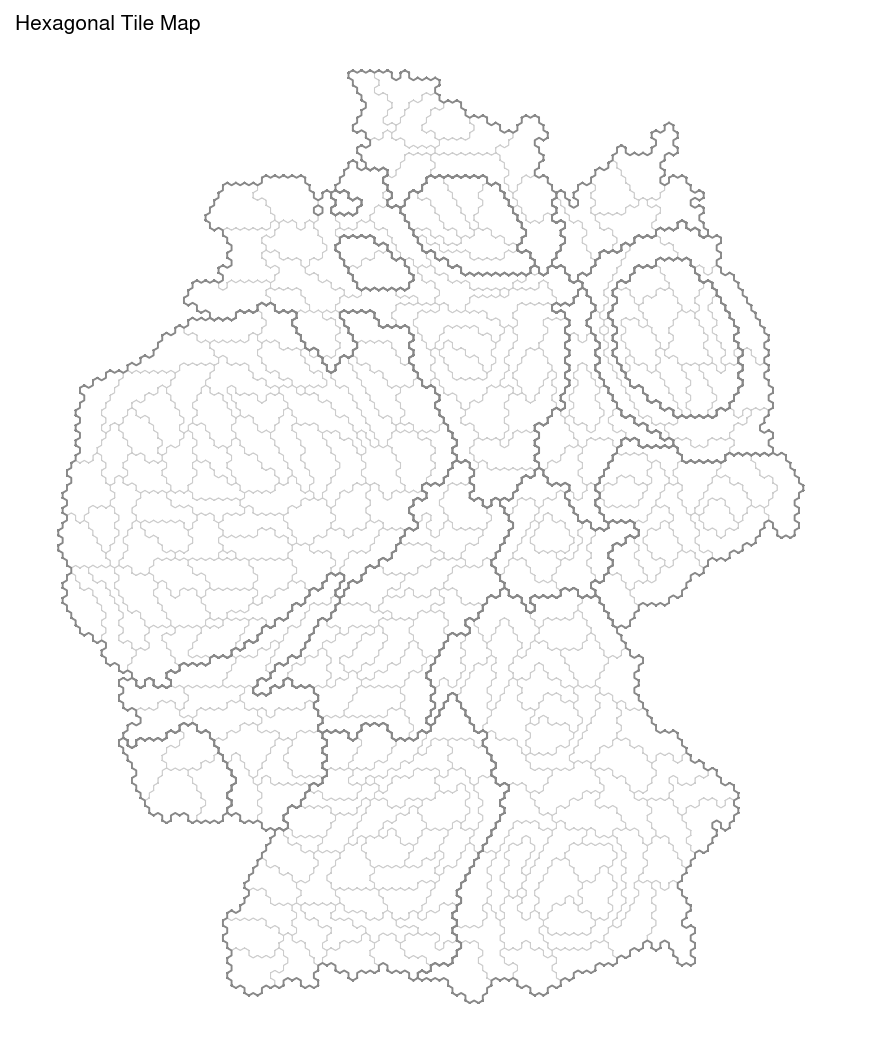

In [17]:
# Visualize hexagonal tile map with state boundaries
ax = hexa_counties.plot(facecolor='w', edgecolor='#cccccc', lw=0.5, figsize=_FIGSIZE)
hexa_counties.dissolve(by='LAND_NR').plot(facecolor='None', edgecolor='#888888', ax=ax, lw=0.9)
ax.set_title('Hexagonal Tile Map')
ax.axis('off')

### Area Comparison: Original vs Hexagonal

This scatter plot compares the hexagonal cartogram area to the vote count. A strong correlation indicates that the hexagonal representation preserves the cartogram's proportionality.

Correlation between original and hexagonal areas: 0.341


/var/folders/lk/6xn0tp_j2hz9nj1g893krwj80000gn/T/ipykernel_77951/2269817989.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


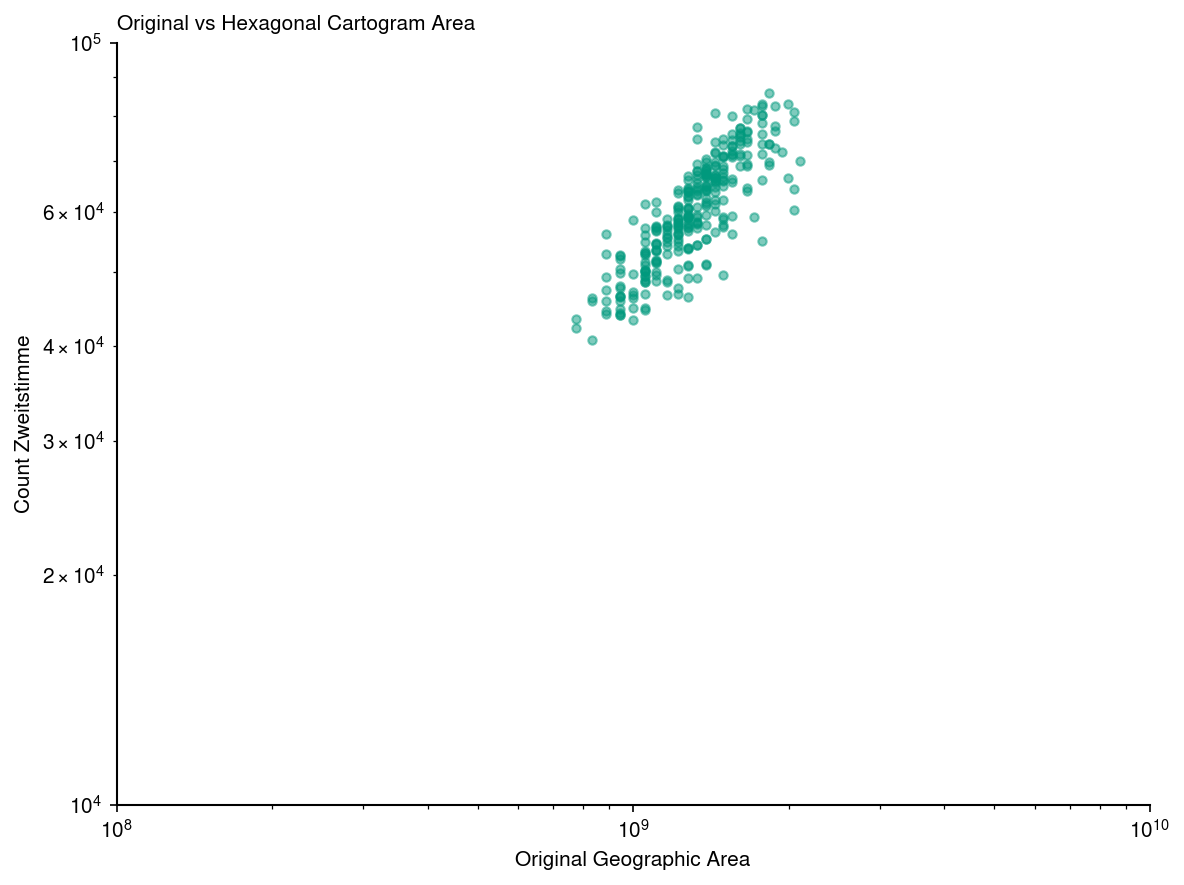

In [18]:
# Compare original area vs hexagonal ward area
original_areas = [g.area for g in gdf['geometry']]
hexagonal_areas = [g.area for g in hexa_counties['geometry']]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(hexagonal_areas, new_gdf['zweitstimme'], alpha=0.5)
ax.set_xlabel('Original Geographic Area')
ax.set_ylabel('Count Zweitstimme')
ax.set_xscale('log')
ax.set_yscale('log')

# Add diagonal reference line
min_val = min(min(original_areas), min(hexagonal_areas))
max_val = max(max(original_areas), max(hexagonal_areas))
#ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='1:1 line')

ax.set_title('Original vs Hexagonal Cartogram Area')
ax.legend()
plt.tight_layout()

# Print correlation
correlation = np.corrcoef(original_areas, hexagonal_areas)[0, 1]
print(f"Correlation between original and hexagonal areas: {correlation:.3f}")

## 7. Comparing Original and Cartogram Maps

Side-by-side comparison showing how the cartogram redistributes visual weight.

### Visual Comparison

The side-by-side view clearly shows the transformation:
- **Left**: Original geographic map where area reflects land size
- **Right**: Cartogram where area reflects vote count

Notice how Berlin (center-east) expands dramatically while Brandenburg shrinks.

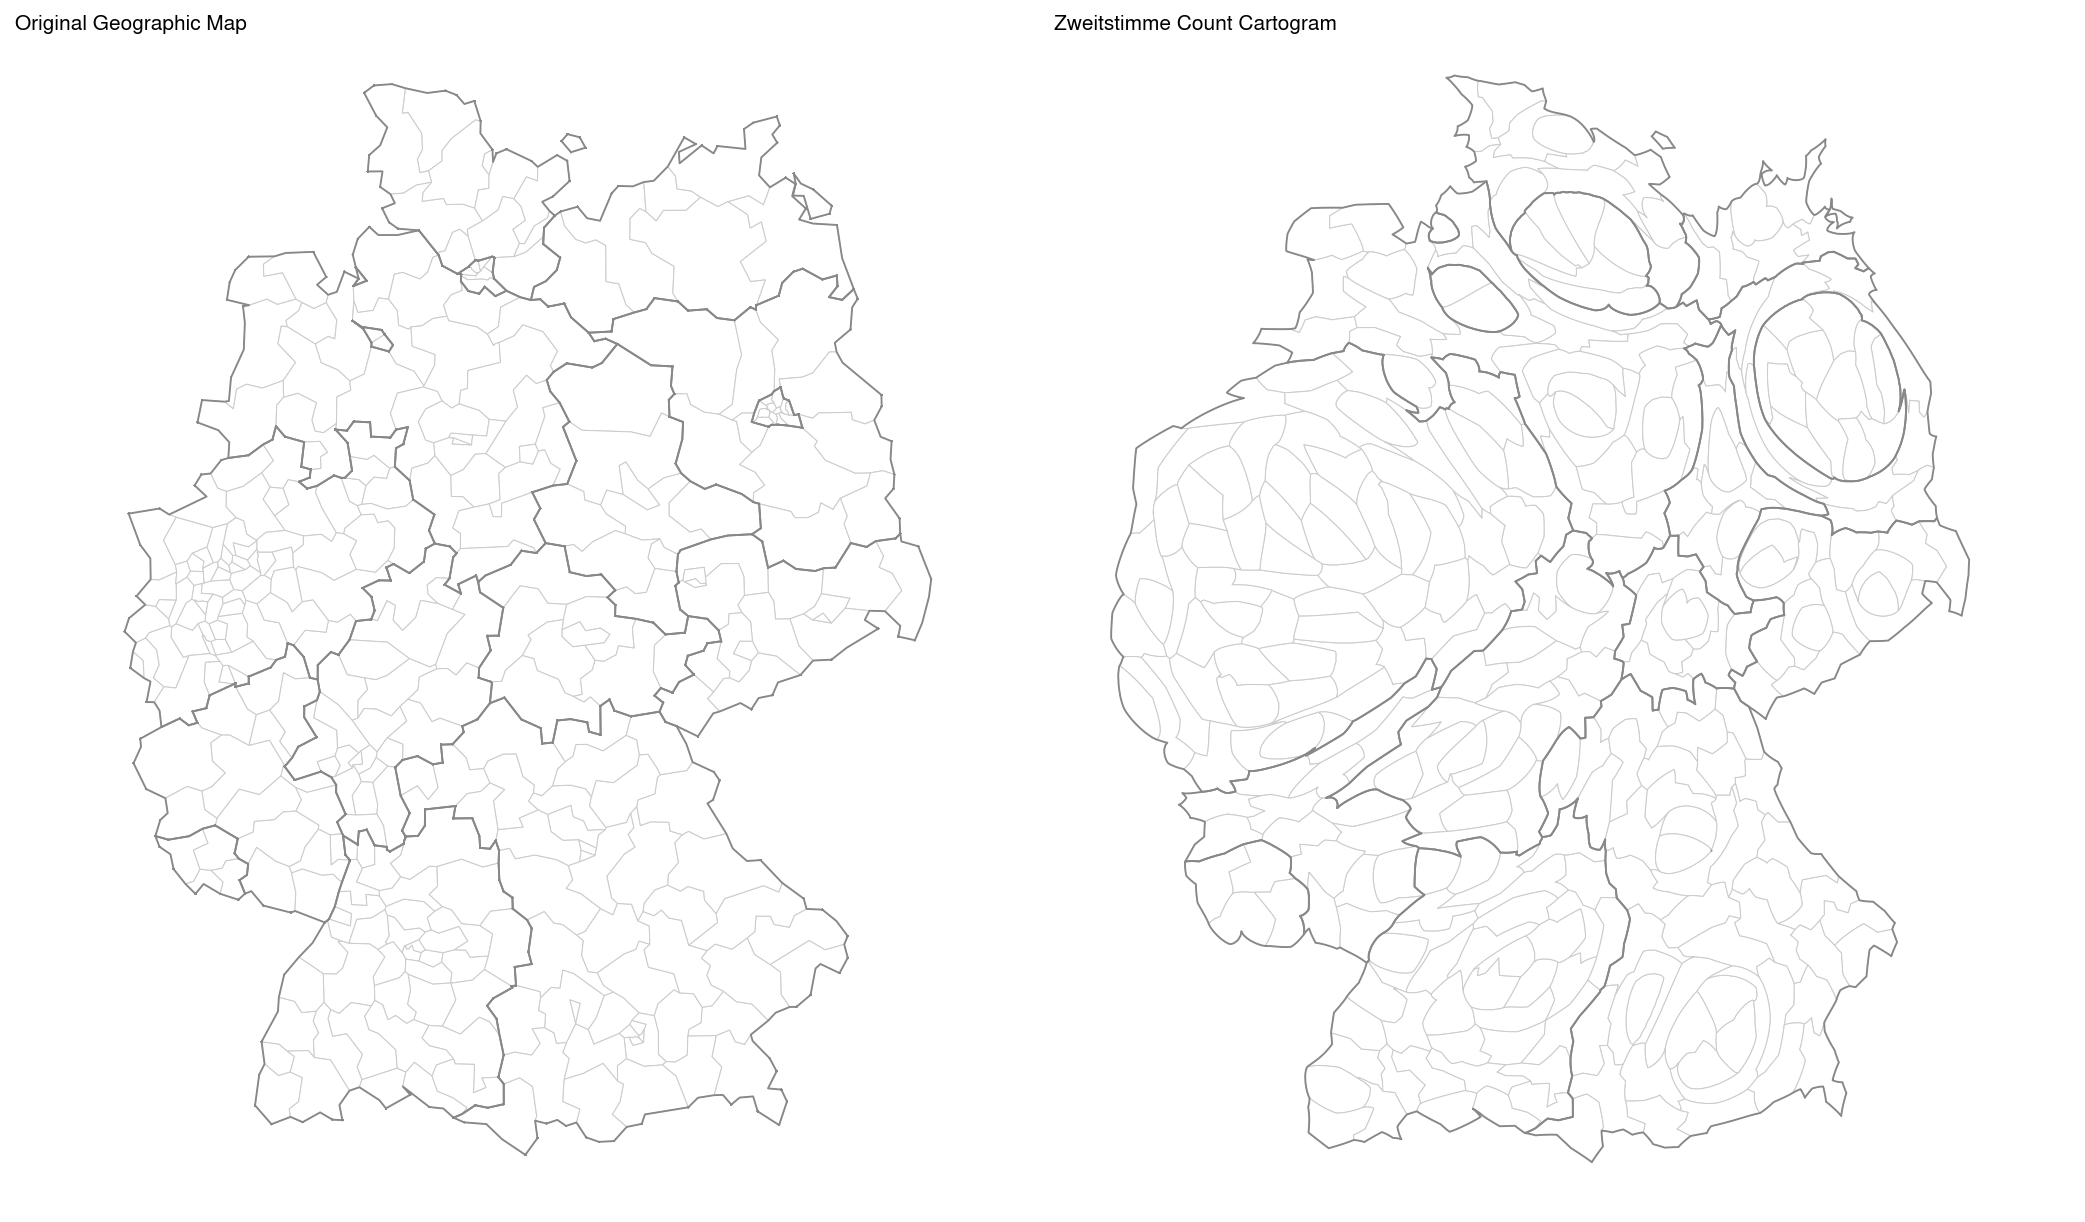

In [19]:
# Side-by-side comparison: Original vs Cartogram
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# Original map
ax = axes[0]
gdf.plot(ax=ax, facecolor='w', edgecolor='#cccccc', lw=0.5)
gdf.dissolve(by='LAND_NR').buffer(0.0001).plot(facecolor='None', edgecolor='#888888', ax=ax, lw=0.9)
ax.set_title('Original Geographic Map')
ax.axis('off')

# Cartogram
ax = axes[1]
new_gdf_valid = fix_geodataframe_geometries(new_gdf)
new_gdf.plot(ax=ax, facecolor='w', edgecolor='#cccccc', lw=0.5)
new_gdf_valid.dissolve(by='LAND_NR').buffer(10).plot(facecolor='None', edgecolor='#888888', ax=ax, lw=0.9)
ax.set_title('Zweitstimme Count Cartogram')
ax.axis('off')

plt.tight_layout()

## 8. Visualizing Election Results

Show winning parties on both original and cartogram maps.

### Erststimme (First Vote) Winners

The Erststimme determines which candidate wins the direct mandate for each district. Colors show the winning party:
- **Black**: CDU/CSU
- **Red**: SPD
- **Green**: Grüne
- **Yellow**: FDP
- **Magenta**: Die Linke
- **Blue**: AfD

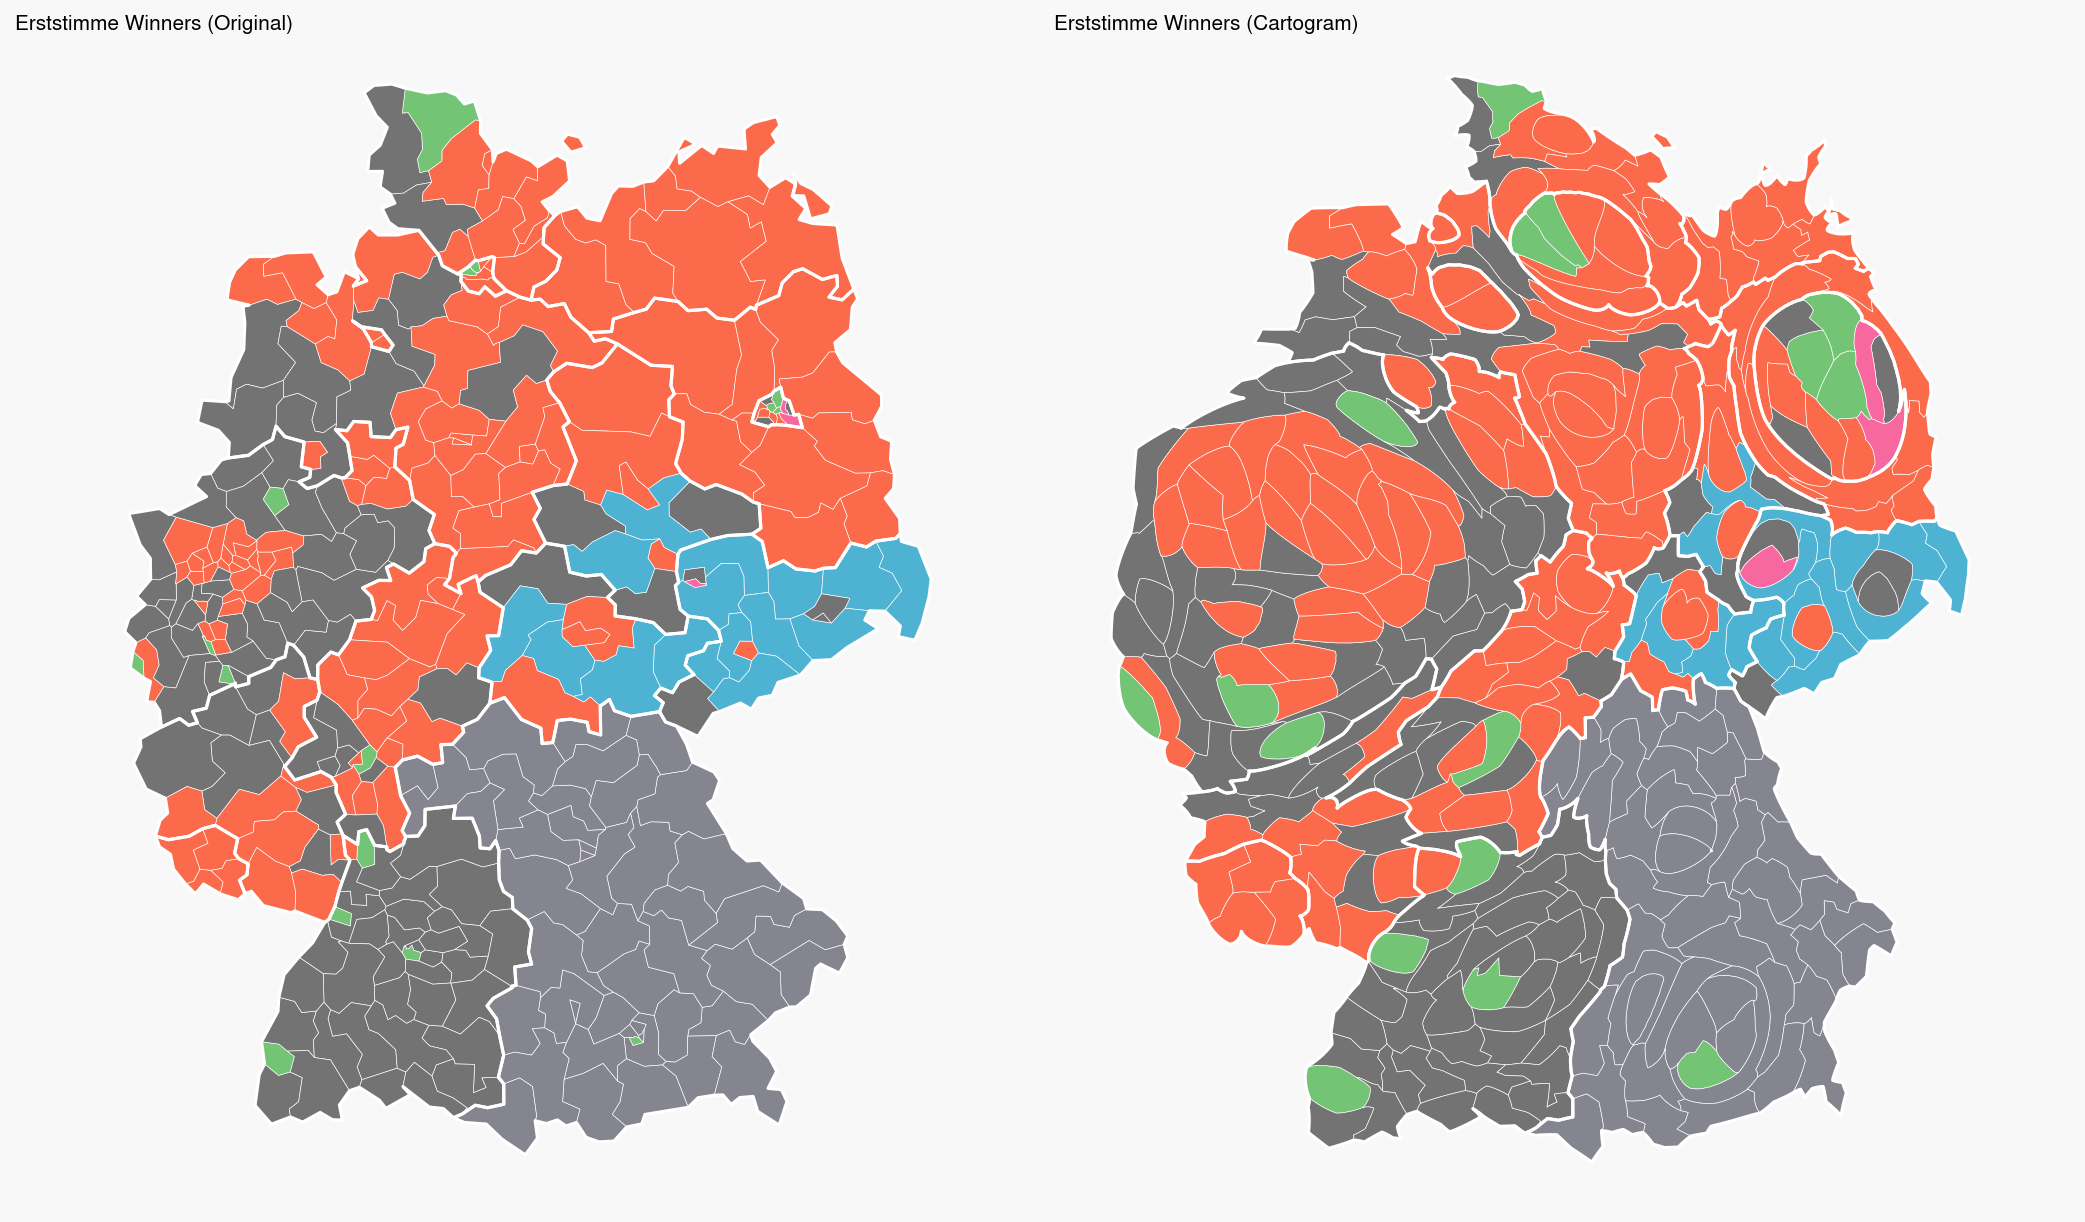

In [20]:
# Election results: Erststimme (direct mandate) winners
plt.rcParams['figure.facecolor'] = '#f8f8f8'

fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# Original map
ax = axes[0]
gdf.plot(ax=ax, edgecolor='#ffffff', color=gdf['colors_gewinner_erststimme'], linewidth=0.3)
gdf.dissolve(by='LAND_NR').buffer(10).plot(facecolor='None', edgecolor='#ffffff', ax=ax, lw=1.5)
ax.set_title('Erststimme Winners (Original)')
ax.axis('off')

# Cartogram
ax = axes[1]
new_gdf.plot(ax=ax, edgecolor='#ffffff', color=new_gdf['colors_gewinner_erststimme'], linewidth=0.3)
new_gdf_valid.dissolve(by='LAND_NR').buffer(10).plot(facecolor='None', edgecolor='#ffffff', ax=ax, lw=1.5)
ax.set_title('Erststimme Winners (Cartogram)')
ax.axis('off')

plt.tight_layout()

### Zweitstimme (Second Vote) Winners

The Zweitstimme determines party representation in the Bundestag via proportional allocation. This shows which party received the most second votes in each district.

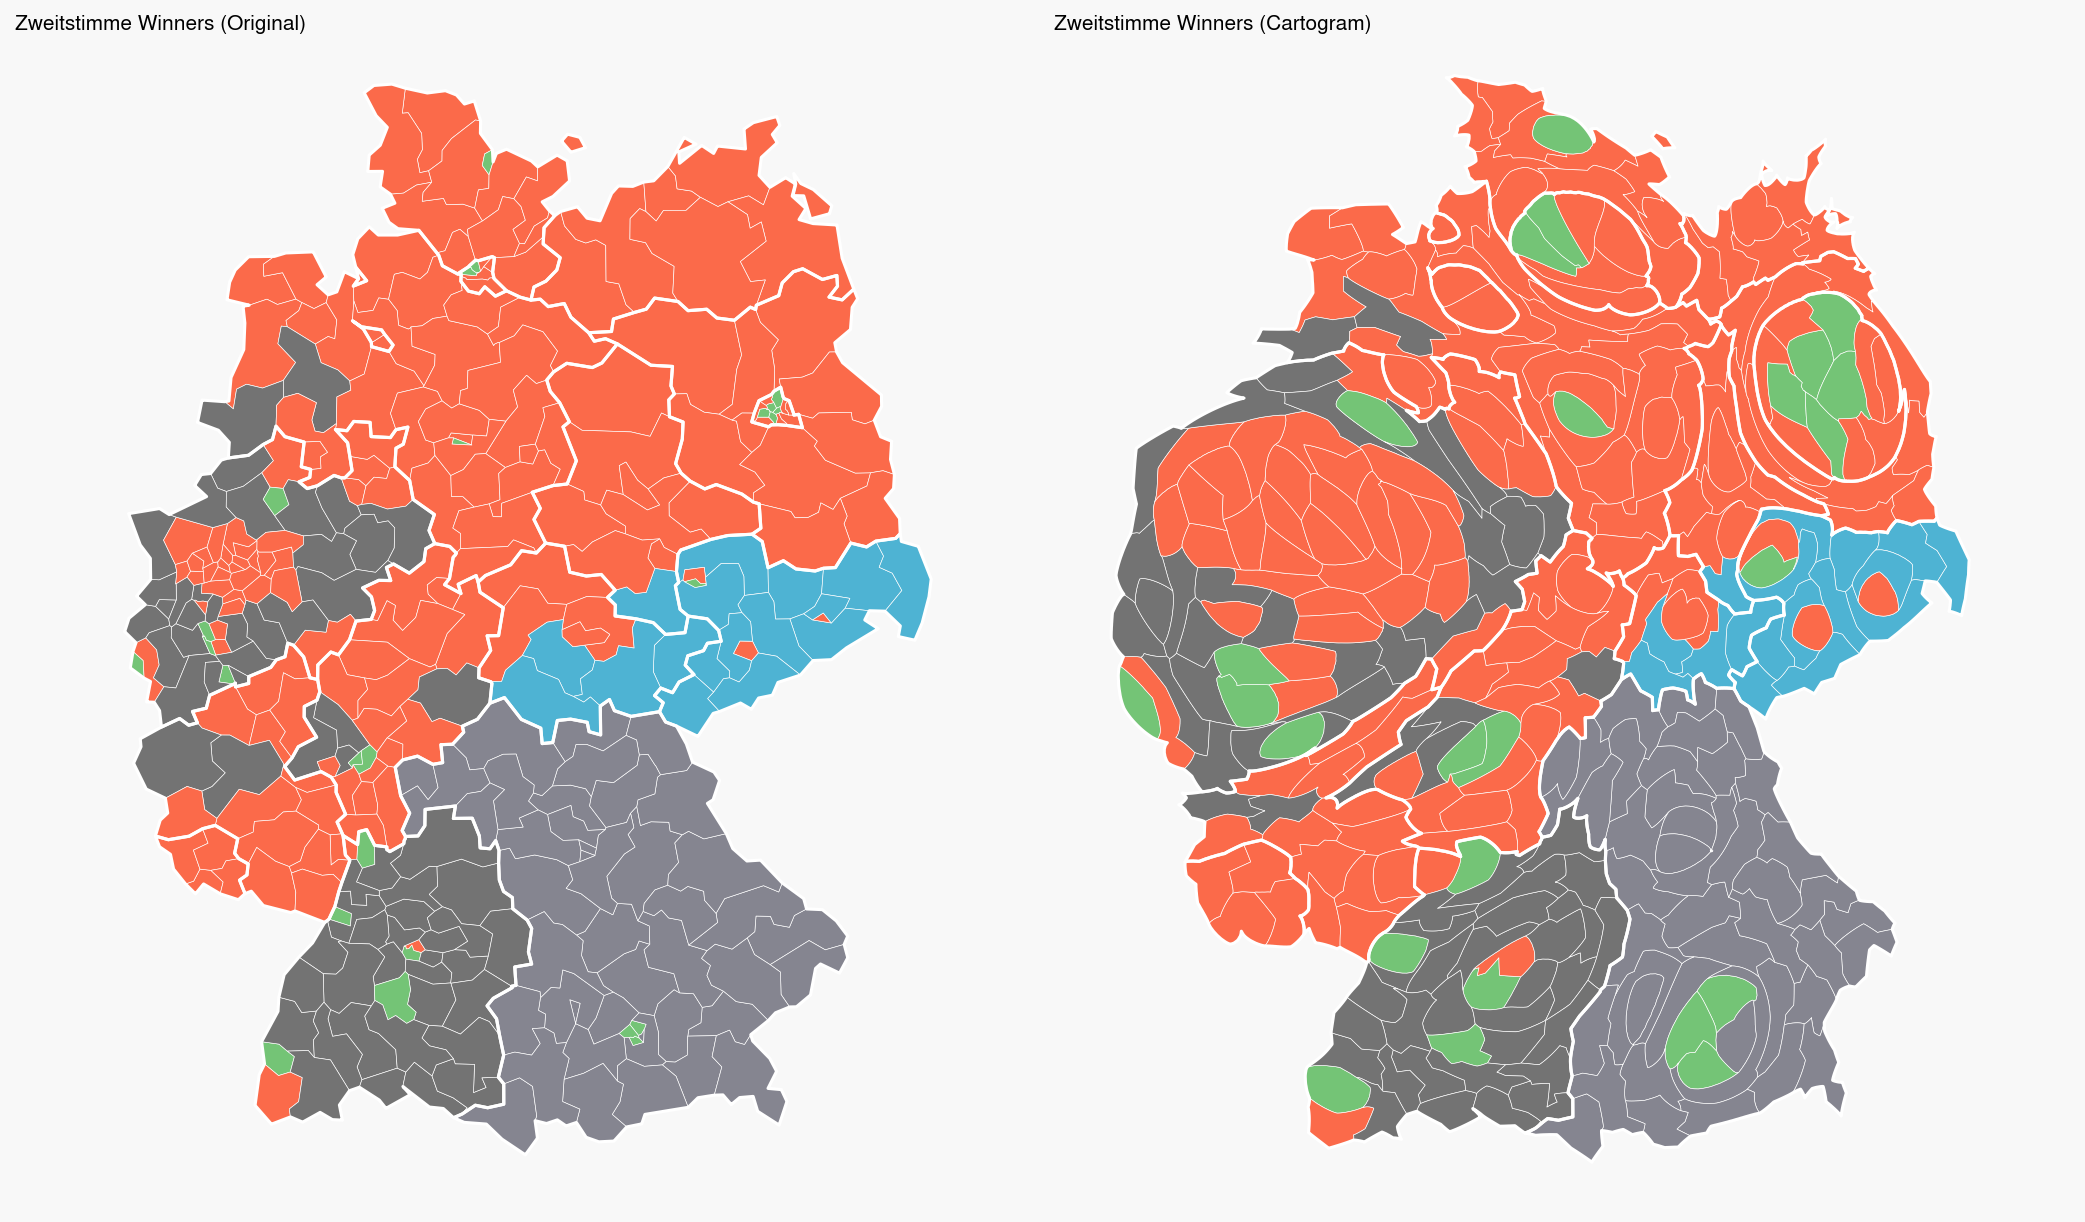

In [21]:
# Election results: Zweitstimme (party vote) winners
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# Original map
ax = axes[0]
gdf.plot(ax=ax, edgecolor='#ffffff', color=gdf['colors_gewinner_zweitstimme'], linewidth=0.3)
gdf.dissolve(by='LAND_NR').buffer(10).plot(facecolor='None', edgecolor='#ffffff', ax=ax, lw=1.5)
ax.set_title('Zweitstimme Winners (Original)')
ax.axis('off')

# Cartogram
ax = axes[1]
new_gdf.plot(ax=ax, edgecolor='#ffffff', color=new_gdf['colors_gewinner_zweitstimme'], linewidth=0.3)
new_gdf_valid.dissolve(by='LAND_NR').buffer(10).plot(facecolor='None', edgecolor='#ffffff', ax=ax, lw=1.5)
ax.set_title('Zweitstimme Winners (Cartogram)')
ax.axis('off')

plt.tight_layout()
plt.rcParams['figure.facecolor'] = '#ffffff'

### Hexagonal Cartogram: Erststimme Winners

Comparing the original map with the hexagonal cartogram for Erststimme winners. The hexagonal version gives equal visual weight to each district's voting population rather than its geographic size.

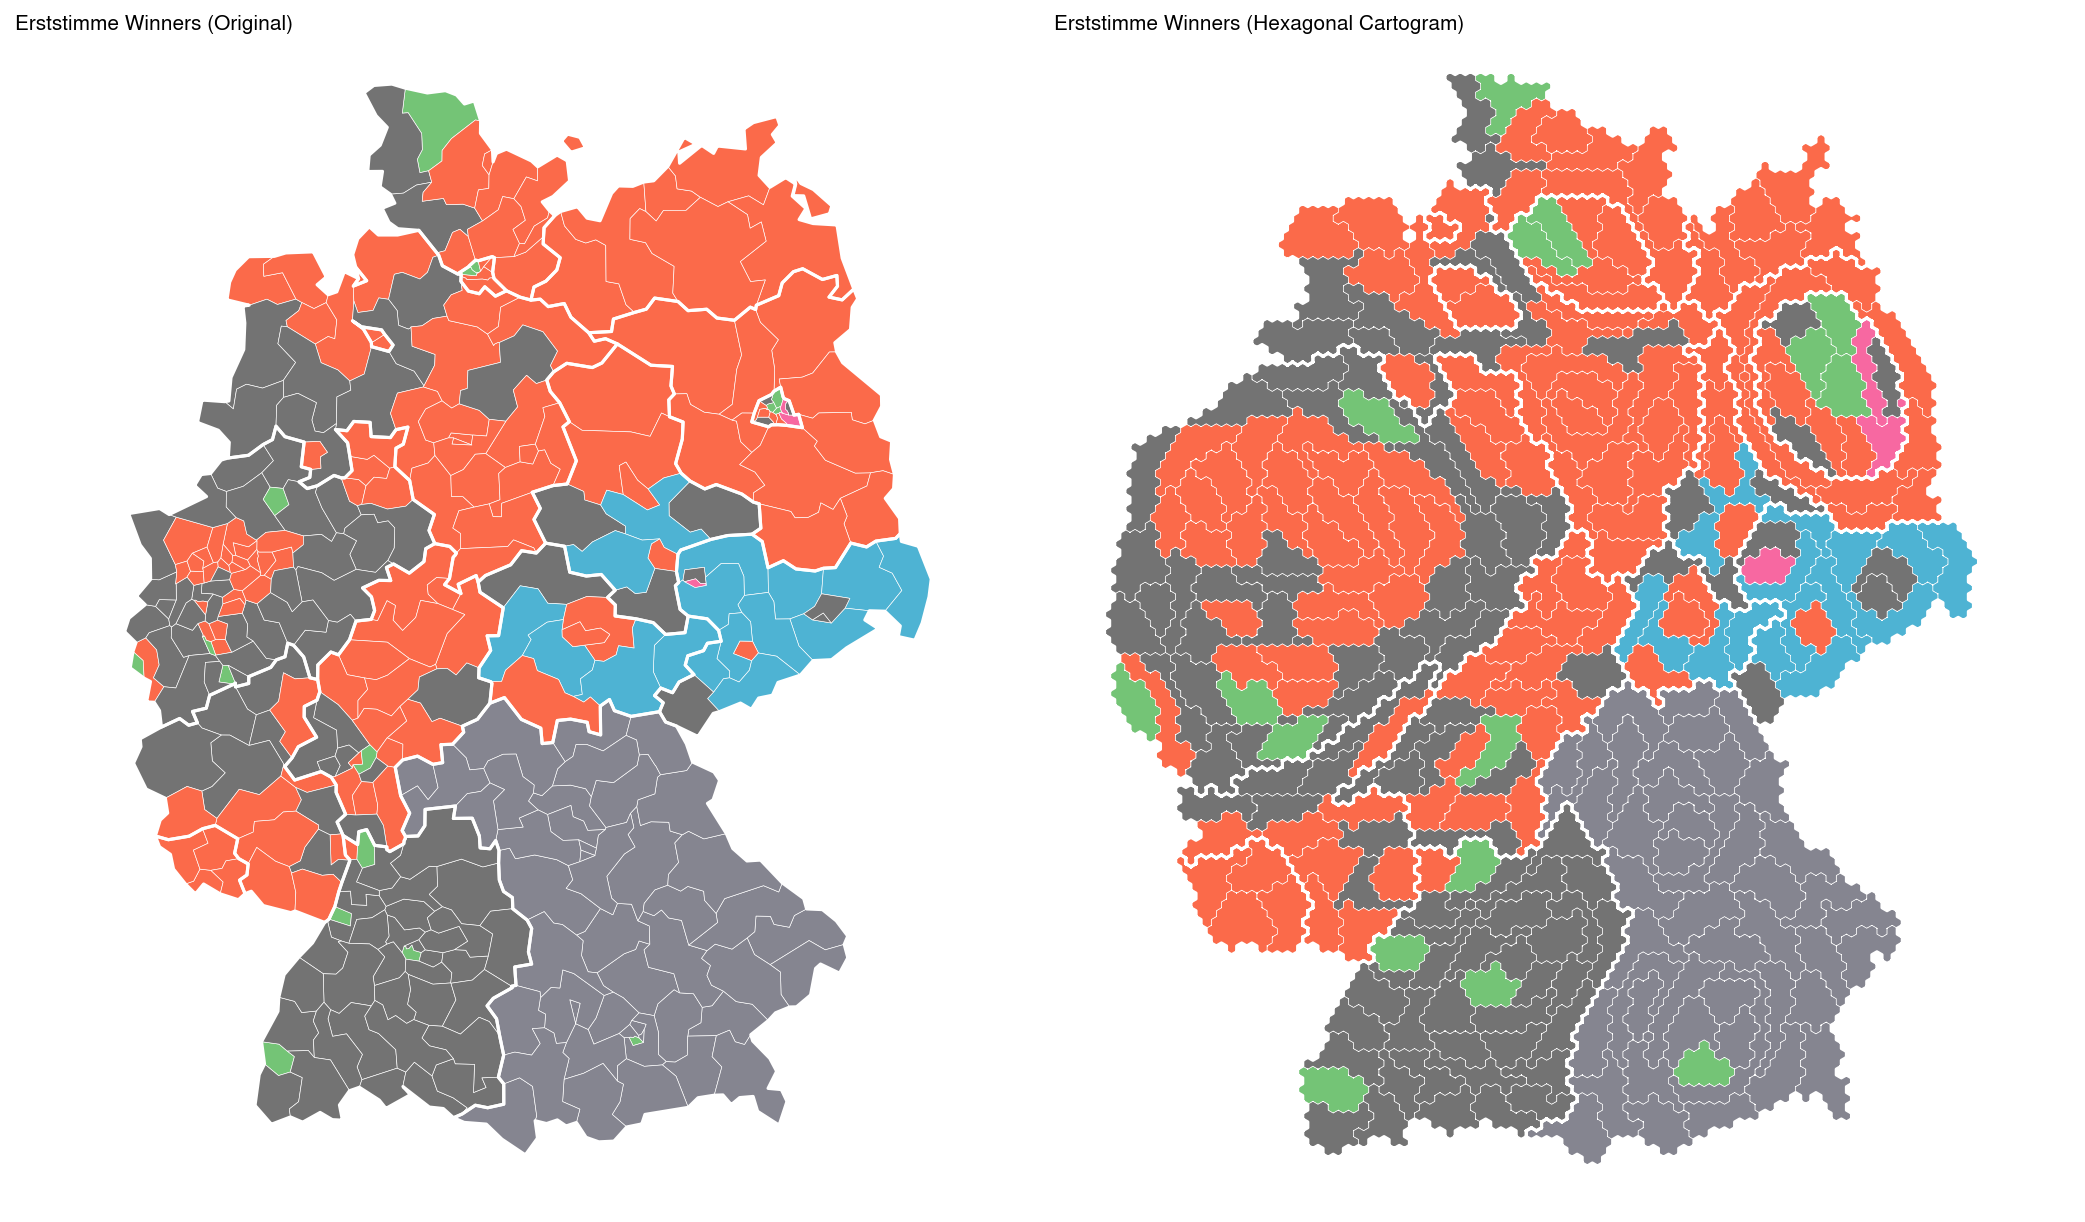

In [22]:
# Election results: Hexagonal cartogram with Erststimme colors
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# Original map
ax = axes[0]
gdf.plot(ax=ax, edgecolor='#ffffff', color=gdf['colors_gewinner_erststimme'], linewidth=0.3)
gdf.dissolve(by='LAND_NR').buffer(10).plot(facecolor='None', edgecolor='#ffffff', ax=ax, lw=1.5)
ax.set_title('Erststimme Winners (Original)')
ax.axis('off')

# Hexagonal cartogram
ax = axes[1]
hexa_counties.plot(ax=ax, edgecolor='#ffffff', color=hexa_counties['colors_gewinner_erststimme'], linewidth=0.3)
hexa_counties.dissolve(by='LAND_NR').plot(facecolor='None', edgecolor='#ffffff', ax=ax, lw=1.5)
ax.set_title('Erststimme Winners (Hexagonal Cartogram)')
ax.axis('off')

plt.tight_layout()
plt.rcParams['figure.facecolor'] = '#ffffff'

## 9. Saving Outputs

Export the cartogram data as GeoJSON.

### Exporting Data

We export the results in GeoJSON format for use in other applications (web maps, GIS software, etc.). The coordinate system is converted to WGS84 (EPSG:4326) for compatibility.

In [23]:
# Save hexagonal tile map as GeoJSON
output_path = 'targetdata/WKR_cartogram_hexagons.json'
hexa_counties[['LAND_NR', 'WKR_NR', 'geometry']].to_crs("EPSG:4326").to_file(
    output_path, driver='GeoJSON'
)
print(f"Saved hexagonal tile map to: {output_path}")

# Save cartogram polygons
with open('targetdata/test.json', 'w') as f:
    f.write(new_gdf.to_json())
print("Saved cartogram polygons to: targetdata/test.json")

Saved hexagonal tile map to: targetdata/WKR_cartogram_hexagons.json
Saved cartogram polygons to: targetdata/test.json


### Saving Figures

Export publication-ready PDF figures of the original map and cartogram.

In [24]:
# Save comparison figures as PDF
ax = gdf.plot(facecolor='w', edgecolor='#cccccc', lw=0.5)
gdf.dissolve(by='LAND_NR').buffer(0.0001).plot(facecolor='None', edgecolor='#888888', ax=ax, lw=0.9)
ax.axis('off')
ax.get_figure().savefig('germany.pdf')
plt.close()

ax = new_gdf.plot(facecolor='w', edgecolor='#cccccc', lw=0.5)
new_gdf_valid.dissolve(by='LAND_NR').buffer(10).plot(facecolor='None', edgecolor='#888888', ax=ax, lw=0.9)
ax.axis('off')
ax.get_figure().savefig('germany_cartogram.pdf')
plt.close()

print("Saved figures: germany.pdf, germany_cartogram.pdf")

Saved figures: germany.pdf, germany_cartogram.pdf


## Summary

This notebook demonstrated creating a **Zweitstimme count cartogram**:

1. **Load data**: Election statistics and district boundaries
2. **Calculate density**: Zweitstimme count / geographic area
3. **Create cartogram**: Distort geography so area reflects vote count
4. **Generate hexagonal grid**: Overlay uniform hexagons on cartogram
5. **Assign hexagons**: Map each hexagon to its primary district
6. **Create tile map**: Dissolve hexagons into district boundaries
7. **Visualize results**: Compare original vs cartogram, show election winners